In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
2019-03-13
{'minibatch_size': 10, 'train_batch_size': 100, 'test_batch_size': 20, 'cmin': 0.1307, 'cmax': 0.3081, 'N_pic': 128, 'offset_std': 8, 'offset_max': 35, 'noise': 1.0, 'contrast': 0.4, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'N_X': 128, 'N_Y': 128, 'rho': 1.41, 'bias_deconv': True, 'dim1': 1000, 'dim2': 1000, 'loss_func': BCEWithLogitsLoss(), 'lr': 0.0001, 'do_adam': False, 'epochs': 10, 'momentum': 0.05, 'n_epochs': 10, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-13', 'seed': 2019}


# Definition of the input and the output 

## Representation of input image (retina)

In [3]:
from retina import Display
d = Display(args)

In [4]:
from retina import Retina
r = Retina(args)

In [5]:
data, label = next(iter(d.loader_test))
idx = 4
data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy())
data_retina = r.retina(data_fullfield)

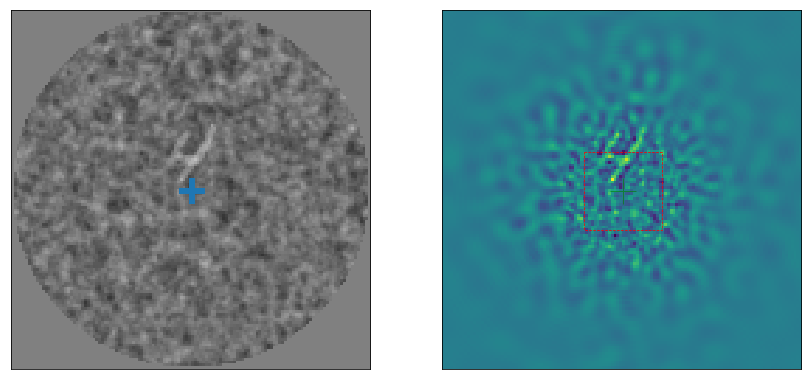

In [7]:
fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0] = d.show(axs[0], data_fullfield)
axs[1] = r.show(axs[1], r.retina_invert(data_retina))

## Representation of output accuracy (colliculus)

In [7]:
path = "../data/MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if args.verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


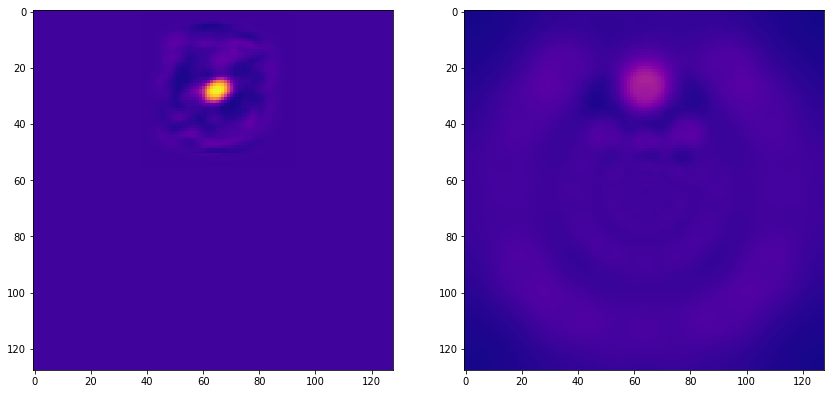

In [8]:
accuracy_colliculus, accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)

fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0].imshow(accuracy_fullfield_map, vmin=0, vmax=1, cmap=plt.plasma())
axs[1].imshow(r.accuracy_invert(accuracy_colliculus), vmin=0, vmax=1, cmap=plt.plasma())


# Evaluating the accuracy of the classifier (What) wrt to spatial shifts

On commence par la fonction de base apprise de la librairie torch, cf https://raw.githubusercontent.com/pytorch/examples/master/mnist/main.py :

In [3]:
%whos

Variable        Type        Data/Info
-------------------------------------
args            EasyDict    {'minibatch_size': 100, '<...>019-03-13', 'seed': 2019}
datetime        module      <module 'datetime' from '<...>b/python3.7/datetime.py'>
dpi_export      int         600
easydict        module      <module 'easydict' from '<...>es/easydict/__init__.py'>
fig_width_pt    int         1024
figwidth        float       14.169088141690882
filename        str         ../data/2019-03-13
inches_per_pt   float       0.013837000138370002
np              module      <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
phi             float64     1.618033988749895
plt             module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
ppi             float       72.27


In [4]:
from what import Net
model = Net()


On apprend une matrice de poids qui est fixée dans la suite et que nous allons utiliser pour la classification

In [5]:
%ls -ltr ../data/MNIST_cnn.pt
#%rm -f ../data/MNIST_cnn.pt

-rw-r--r--  1 lolo  staff  1725644 Mar  7 10:35 ../data/MNIST_cnn.pt


In [8]:
model_path = "../data/MNIST_cnn.pt"

import os
import torch
if os.path.isfile(model_path):
    print('Loading')
    #model = torch.load(model_path)
    model.load_state_dict(torch.load(model_path))
else:
    print('Learning')
    import time
    t0 = time.time()
    %run what.py --epochs 10 --save-model
    print('Done in ', time.time() - t0, 'seconds')

Loading


NameError: name 'model' is not defined

## Using the learned classifier in a standalone class

Maintenant qu'on a appris les points qui permet une classification d'à peu près 98 % on va utiliser le modèle fead-forward pour faire la classification.

In [7]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

In [8]:
model = Net()
model.load_state_dict(torch.load(model_path))
from what import test
accuracy = test(args, model, torch.device("cpu"), d.loader_test)
print('accuracy=', accuracy)


Test set: Average loss: 0.0322, Accuracy: 9894/10000 (99%)

accuracy= 0.9894


## shifting the input images


Je vais maintenant générer des données en utilisant les données originales de MNIST translatées :

In [9]:
from torchvision import datasets, transforms
i_shift, j_shift = 12, 17
N_pix = 28

In [10]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

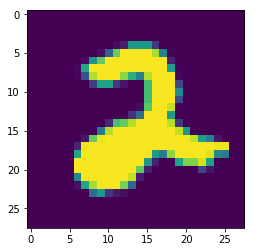

In [11]:
fig, ax = plt.subplots()
ax.imshow(data[0, 0, :, :].numpy())

(1000, 1, 82, 82)


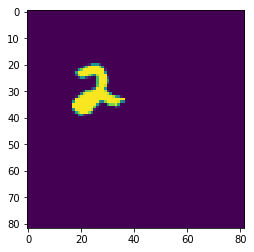

In [12]:
data = data.numpy()
data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 2, N_pix*3 - 2))
print(data_translate.shape)
data_translate[:, :, (N_pix-i_shift):(2*N_pix-i_shift), (N_pix-j_shift):(2*N_pix-j_shift)] = data
fig, ax = plt.subplots()
ax.imshow(data_translate[0, 0, :, :])

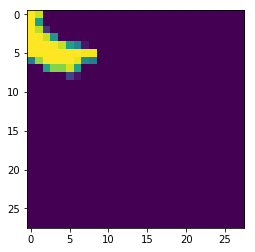

In [13]:
data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

In [14]:
np.arange(-N_pix+1, N_pix)

array([-27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
       -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27])

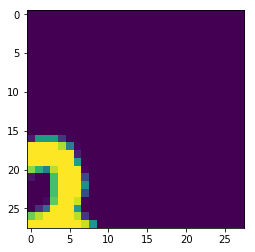

In [15]:
def shift_data(data, i_shift, j_shift):
    N_pix = data.shape[-1]
    assert(N_pix == data.shape[-2])
    import numpy as np
    data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 1, N_pix*3 - 1))
    data_translate[:, :, (N_pix+i_shift):(2*N_pix+i_shift), (N_pix+j_shift):(2*N_pix+j_shift)] = data
    data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
    return data_cropped

data_cropped = shift_data(data, i_shift = 12, j_shift = -12)
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

## Using the learned classifier on the shifted data

On peut maintenant tester le classifieur sur les images Translatées en calculant la valeur de classification en  fonction de l'erreur de localisation

In [16]:
def test_shift(test_loader, i_shift, j_shift, verbose=0):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data_cropped = shift_data(data, i_shift=i_shift, j_shift=j_shift)        
        data_cropped = torch.FloatTensor(data_cropped) #transforms.ToTensor()(data_cropped)
        data_cropped, target = Variable(data_cropped, volatile=True), Variable(target)
        output = model(data_cropped)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose: print('\nTest set: at ({}, {}), the  average loss is {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        i_shift, j_shift, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


path = "../data/MNIST_accuracy.npy"

import os
if os.path.isfile(path):
    print('Loading accuracy')
    accuracy = np.load(path)
else:
    print('Computing accuracy')
    import time
    t0 = time.time()
    accuracy = np.zeros((2*N_pix-1, 2*N_pix-1))
    from tqdm import tqdm
    N_step = 1

    with tqdm(total=(2*N_pix-1)**2/N_step**2) as pbar:
        for i_shift in np.arange(-N_pix+1, N_pix, N_step):
            for j_shift in np.arange(-N_pix+1, N_pix, N_step):
                accuracy[i_shift+N_pix-1, j_shift+N_pix-1] = test_shift(test_loader, i_shift, j_shift)
                pbar.update()
    np.save(path, accuracy)
    print('Done in ', time.time() - t0, 'seconds')
    
print('accuracy=', accuracy)    

Loading accuracy
accuracy= [[0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 ...
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]]


J'avoue que c'est un peu bourrin de calculer la classification sur les 128 × 128 pixels pour 1000 batch multiplié par 10 type d'entrées.... Mais bon on doit faire ça seulement une fois :-) (et sur CPU une classif = environ 300µs ...)

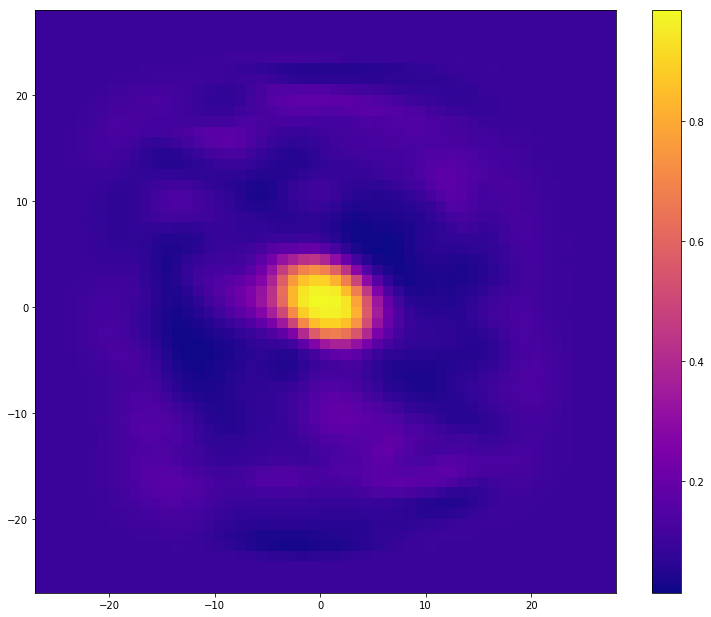

In [23]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pix+1, N_pix+1), np.arange(-N_pix+1, N_pix+1), accuracy, cmap=plt.plasma())
ax.axis('equal')
fig.colorbar(cmap)

Cette fonction de performance du classifieur  est calculée indépendamment de la forme spécifique du chiffre entre 0 et 9. Elle donne donc la carte de performance qu'on attend Au niveau de la classification/ On va pouvoir maintenant l'utiliser ceomm label pour apprendre de façon supervisée la correspondance entre la carte log-polaire obtenue depuis l'image brute et cette carte de performance.

# Retinotopic mapping

## Orientation invariant power encoding (colliculus??)

In [18]:
from retina import Retina
r = Retina(args)

In [19]:
print('r.colliculus.shape=', r.colliculus.shape)

r.colliculus.shape= (16, 10, 16384)


In [20]:
print('r.colliculus_vector.shape=', r.colliculus_vector.shape)

r.colliculus_vector.shape= (160, 16384)


In [21]:
print('r.colliculus_inverse.shape=', r.colliculus_inverse.shape)

r.colliculus_inverse.shape= (16384, 160)


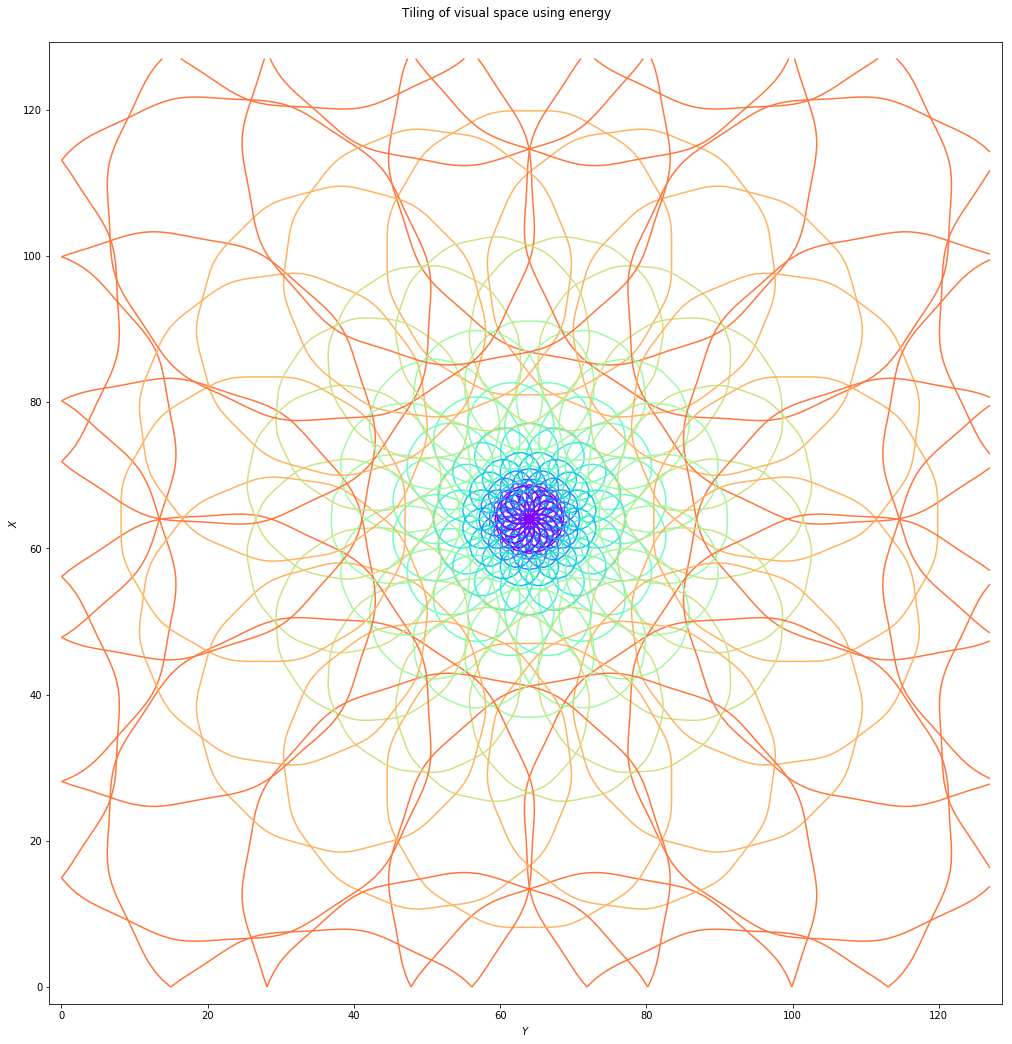

In [22]:
energy = (r.retina_transform**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((args.N_azimuth*args.N_eccentricity, args.N_pic**2))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(figwidth, figwidth))
for i_orient in range(args.N_azimuth):
    for i_scale in range(args.N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((args.N_pic, args.N_pic))
        ax.contour(energy[i_orient, i_scale, :].reshape((args.N_pic, args.N_pic)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/args.N_azimuth)])
fig.suptitle('Tiling of visual space using energy', y=1.02)
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()